## Author: Akash

### Visualising 3 Way Correlations between redlining index, rental index and minority populations

Data Source: Geofiles generated from the spatial outlining step, Rental Prioritisation Index (Urban Institute), ACS 5 Year Survey 2010 (US Census Bureau), ACS 5 Year Survey 2018 (US Census Bureau)

In [ ]:
#Loading needed libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import fiona
from shapely.geometry import shape, mapping
import rtree
import fiona.crs
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os
import splot
import pysal
from libpysal import weights
import esda
from esda.moran import Moran, Moran_Local,Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation, moran_scatterplot

In [ ]:
#Reading the rent prioritisation data made available by the Urban Institute 
rent_data = gpd.read_file('/datasets/rent_prioritisation/housing_index_state_adj.geojson')

In [ ]:
#Reading the redlined data
geo_files = [
"/home/jovyan/work/COVIDRedlining/data/dallas/dallas_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/detroit/detroit_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/new york/ny_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/minneapolis/minneapolis_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/california/cali_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/boston/boston_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/tampa/tampa_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/newark/newark_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/chicago/chicago_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/atlanta/atlanta_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/houston/houston_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/nashville/nashville_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/stlouis/stlouis_redlined_numerical_values.geojson"
]

dfs = [gpd.read_file(x) for x in geo_files]

In [ ]:
#Combining all geo-files together and rounding the reweighted redline index to 2 decimal values
geo_intersect = pd.DataFrame(pd.concat(dfs))
geo_intersect['reweighted_redline_index'] = geo_intersect['reweighted_redline_index'].round(2)
geo_intersect.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,reweighted_redline_index,ordinal_value,geometry
0,48,113,980100,4.811398e+10,9801,Census Tract 9801,G5020,S,5493433,0,+32.8455619,-096.8494250,3.10,4,"POLYGON ((-96.86907 32.84576, -96.86893 32.846..."
1,48,113,000605,4.811300e+10,6.05,Census Tract 6.05,G5020,S,537957,0,+32.8104817,-096.8071671,2.09,3,"POLYGON ((-96.81350 32.81280, -96.81263 32.813..."
2,48,113,007101,4.811301e+10,71.01,Census Tract 71.01,G5020,S,1180246,0,+32.8443119,-096.8175334,1.00,1,"POLYGON ((-96.82198 32.83702, -96.82187 32.837..."
3,48,113,004201,4.811300e+10,42.01,Census Tract 42.01,G5020,S,2569176,9714,+32.7584519,-096.8299088,2.16,3,"POLYGON ((-96.83757 32.75015, -96.83756 32.750..."
4,48,113,005901,4.811301e+10,59.01,Census Tract 59.01,G5020,S,2898961,0,+32.6930920,-096.8082157,3.00,3,"POLYGON ((-96.81470 32.69375, -96.81467 32.695..."


In [ ]:
#Merging geofiles with the rental prioritisation index data
rent_data['GEOID'] = rent_data['GEOID'].astype(float)
rent_redline_data = geo_intersect.merge(rent_data,on='GEOID',how='left',suffixes=('_redline','_rent'))
rent_redline_data.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,z_score_perc_poverty_12mnth_quantile,z_score_perc_no_hinsure_quantile,z_score_perc_person_of_color_quantile,z_score_perc_public_assistance_quantile,z_score_perc_foreign_born_quantile,z_score_perc_30hamfi_quantile,z_score_perc_low_income_jobs_lost_quantile,num_ELI,grayed_out,geometry_rent
0,48,113,980100,4.811398e+10,9801,Census Tract 9801,G5020,S,5493433,0,...,0.01,0.01,0.99,0.17,0.97,0.05,0.91,0.0,1.0,"MULTIPOLYGON (((-96.86607 32.84849, -96.86446 ..."
1,48,113,000605,4.811300e+10,6.05,Census Tract 6.05,G5020,S,537957,0,...,0.19,0.07,0.19,0.26,0.67,0.48,0.88,170.0,0.0,"MULTIPOLYGON (((-96.81350 32.81280, -96.80998 ..."
2,48,113,007101,4.811301e+10,71.01,Census Tract 71.01,G5020,S,1180246,0,...,0.39,0.02,0.07,0.41,0.55,0.26,0.86,60.0,0.0,"MULTIPOLYGON (((-96.82185 32.83737, -96.82160 ..."
3,48,113,004201,4.811300e+10,42.01,Census Tract 42.01,G5020,S,2569176,9714,...,0.62,0.53,0.62,0.53,0.63,0.51,0.67,160.0,0.0,"MULTIPOLYGON (((-96.83745 32.75238, -96.83746 ..."
4,48,113,005901,4.811301e+10,59.01,Census Tract 59.01,G5020,S,2898961,0,...,0.79,0.59,0.92,0.91,0.50,0.88,0.48,265.0,0.0,"MULTIPOLYGON (((-96.81463 32.70297, -96.81458 ..."


In [ ]:
#Subsetting the data for running correlations
corr_data = rent_redline_data[['GEOID','state_name','county_name','total_index_quantile','perc_person_of_color','ordinal_value']]
corr_data.head()

,GEOID,state_name,county_name,total_index_quantile,perc_person_of_color,ordinal_value
0,4.811398e+10,Texas,Dallas County,0.54,1.000000,4
1,4.811300e+10,Texas,Dallas County,0.37,0.269623,3
2,4.811301e+10,Texas,Dallas County,0.21,0.158301,1
3,4.811300e+10,Texas,Dallas County,0.67,0.687595,3
4,4.811301e+10,Texas,Dallas County,0.81,0.965158,3


In [ ]:
#Renaming the columns
corr_data = corr_data.rename(columns={'total_index_quantile':'rental_assistance_index','perc_person_of_color':'percentage_minority','ordinal_value':'redlining_index'})

In [ ]:
#Subsetting the data to only include the 14 cities under study
states = ['New York','California','Illinois','Michigan','Missouri','Texas','Georgia','Tennessee','Massachusetts','New Jersey','Minnesota','Florida']
counties = ['Kings County','Richmond County', 'Bronx County', ' Queens County', 'New York County',
'Los Angeles County','San Francisco County','Cook County','Wayne County','St. Louis County','Harris County',
'Dallas County','Fulton County','Davidson County','Suffolk County','Essex County','Hennepin County','Hillsborough County']
corr_data = corr_data[corr_data['state_name'].isin(states)]
corr_data = corr_data[corr_data['county_name'].isin(counties)]
corr_data.shape

(5574, 6)

In [ ]:
#Assigning a new column having the city name against each census tract
def city_name(row):
    if row['county_name'] == 'Kings County':
      val = 'New York'
    elif row['county_name'] == 'Richmond County':
      val = 'New York'
    elif row['county_name'] == 'Bronx County':
      val = 'New York'
    elif row['county_name'] == ' Queens County':
      val = 'New York'
    elif row['county_name'] == 'New York County':
      val = 'New York'
    elif row['county_name'] == 'Los Angeles County':
      val = 'Los Angeles'
    elif row['county_name'] == 'San Francisco County':
      val = 'San Francisco'
    elif row['county_name'] == 'Cook County':
      val = 'Chicago'
    elif row['county_name'] == 'Wayne County':
      val = 'Detroit'
    elif row['county_name'] == 'St. Louis County':
      val = 'St. Louis'
    elif row['county_name'] == 'Harris County':
      val = 'Houston'
    elif row['county_name'] == 'Dallas County':
      val = 'Dallas' 
    elif row['county_name'] == 'Fulton County':
      val = 'Atlanta'
    elif row['county_name'] == 'Davidson County':
      val = 'Nashville' 
    elif row['county_name'] == 'Suffolk County' and row['state_name'] == 'Massachusetts':
      val = 'Boston'
    elif row['county_name'] == 'Essex County':
      val = 'Newark'
    elif row['county_name'] == 'Hennepin County':
      val = 'Minneapolis' 
    elif row['county_name'] == 'Hillsborough County':
      val = 'Tampa' 
    else:
      val = 0

    return val

corr_data['city_name'] = corr_data.apply(city_name, axis=1)

## 3-Way Correlations (Spearman)

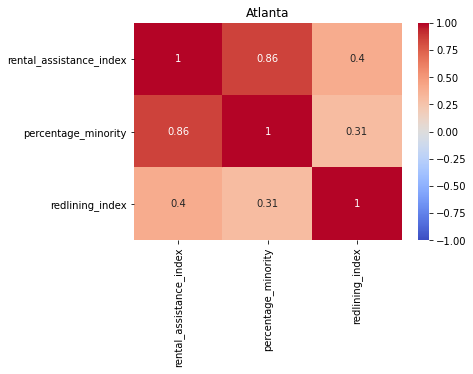

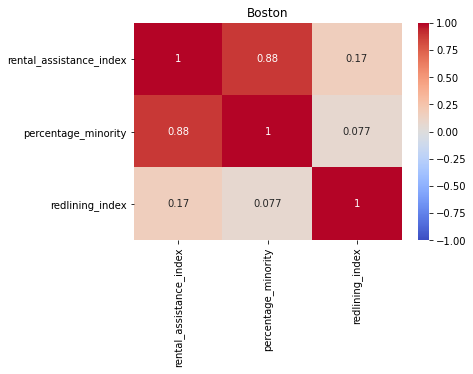

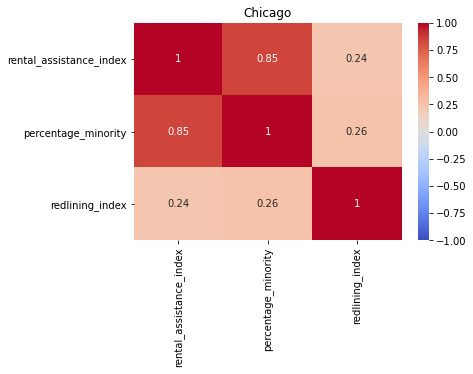

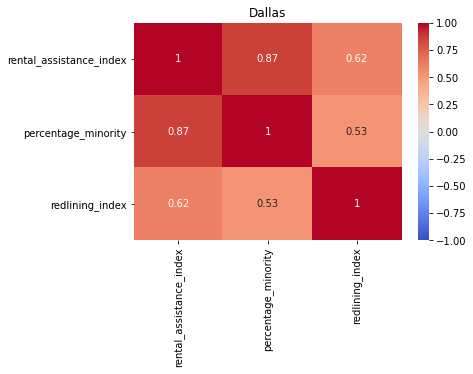

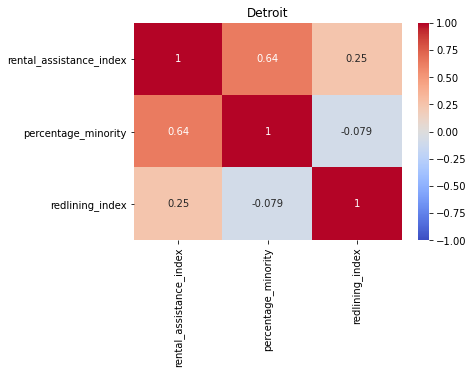

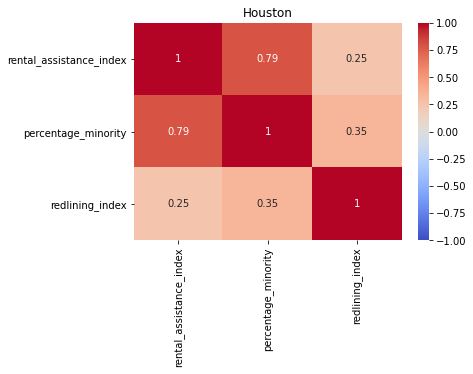

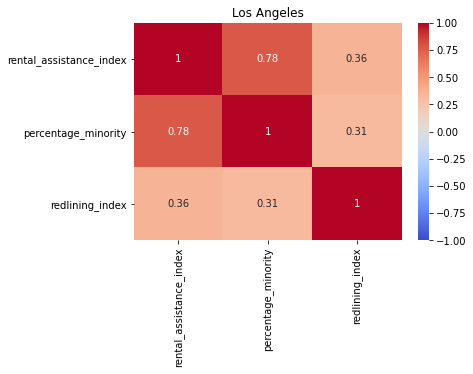

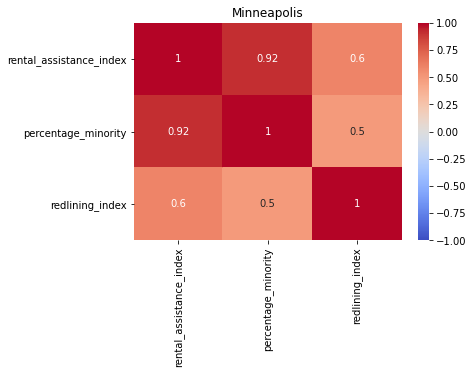

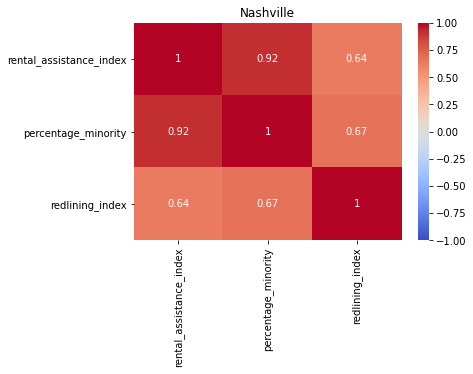

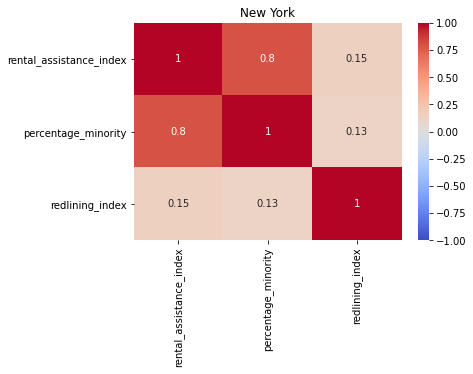

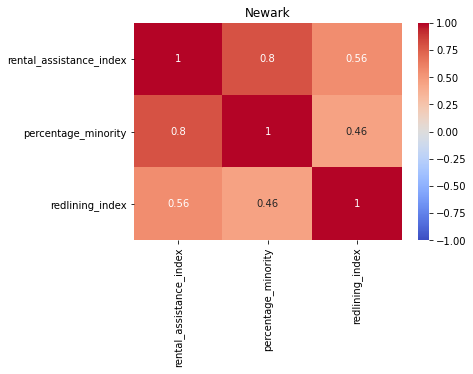

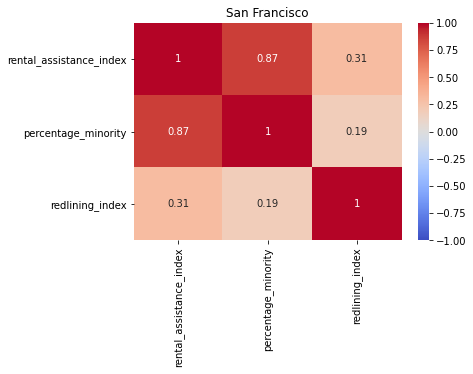

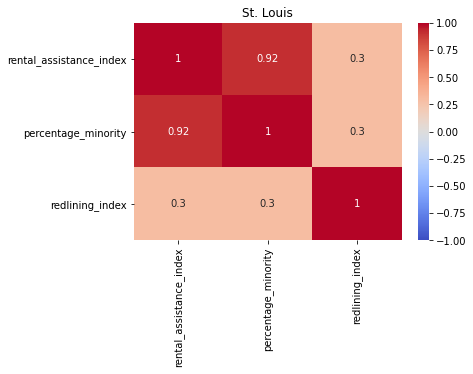

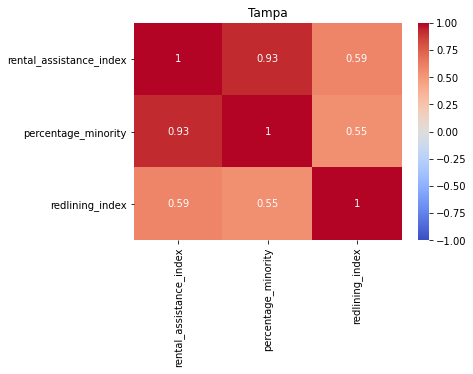

In [ ]:
#Atlanta

cities = ['Atlanta','Boston','Chicago','Dallas','Detroit','Houston','Los Angeles','Minneapolis','Nashville','New York','Newark','San Francisco','St. Louis','Tampa']

for i in cities:
    ax = plt.axes()
    sns.heatmap(corr_data[corr_data['city_name']==i][['rental_assistance_index','percentage_minority','redlining_index']].corr(method='spearman'),annot=True,vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

    ax.set_title(i)
    plt.show()

In [ ]:
Right - Major Minority - 4 shadows 80-100% minority but 3 is distributed to non-white tract
Normal - Diverse? 3&4 spread across all tracts, majorly for 40-60% minority tracts
Left - Gentrified? - 3&4 distributed to major non-white tracts - bet 0-30%
Uniform/Bimodal - Equally distributed across tracts ? For bimodal - heavily segregated? 

Compare Cities -- Right Skewed

In [ ]:
# Plotting distribution of redlining tracts across cities 

for i in minority_hist_df['city_name'].unique():
    ax = sns.displot(minority_hist_df[minority_hist_df['city_name']==i]['perc_person_of_color'], bins = 50, kde= True)
    ax = sns.displot(minority_hist_df[minority_hist_df['city_name']==i][''], bins = 50, kde= True)
    if minority_hist_df[minority_hist_df['city_name']==i]['perc_person_of_color'].count() < 450:
        vmin = 0
        vmax = 20
    else:
        vmin = 0
        vmax = 300
        
    plt.ylim(vmin,vmax)
    mean=minority_hist_df['perc_person_of_color'].mean()
    plt.axvline(mean,color='b', linestyle='--')
    plt.legend({'Mean':mean})
    ax = sns.displot(minority_hist_df[minority_hist_df['city_name']==i]['perc_person_of_color'], kind='kde').set(xlim=(0))
    ax.set_axis_labels(i)

## Exploring Gentrification in Atlanta

In [ ]:
#Atlanta Racial Minority and Rental Assistance Correlation

atlanta_counties = ['Fulton County']

atlanta = spatial_corr_data[(spatial_corr_data['county_name'].isin(atlanta_counties))]

atlanta = atlanta.dropna()

y = atlanta['total_index_quantile'].values
w = Queen.from_dataframe(atlanta)
w.transform = 'R'
x = atlanta['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

0.33974954098955684

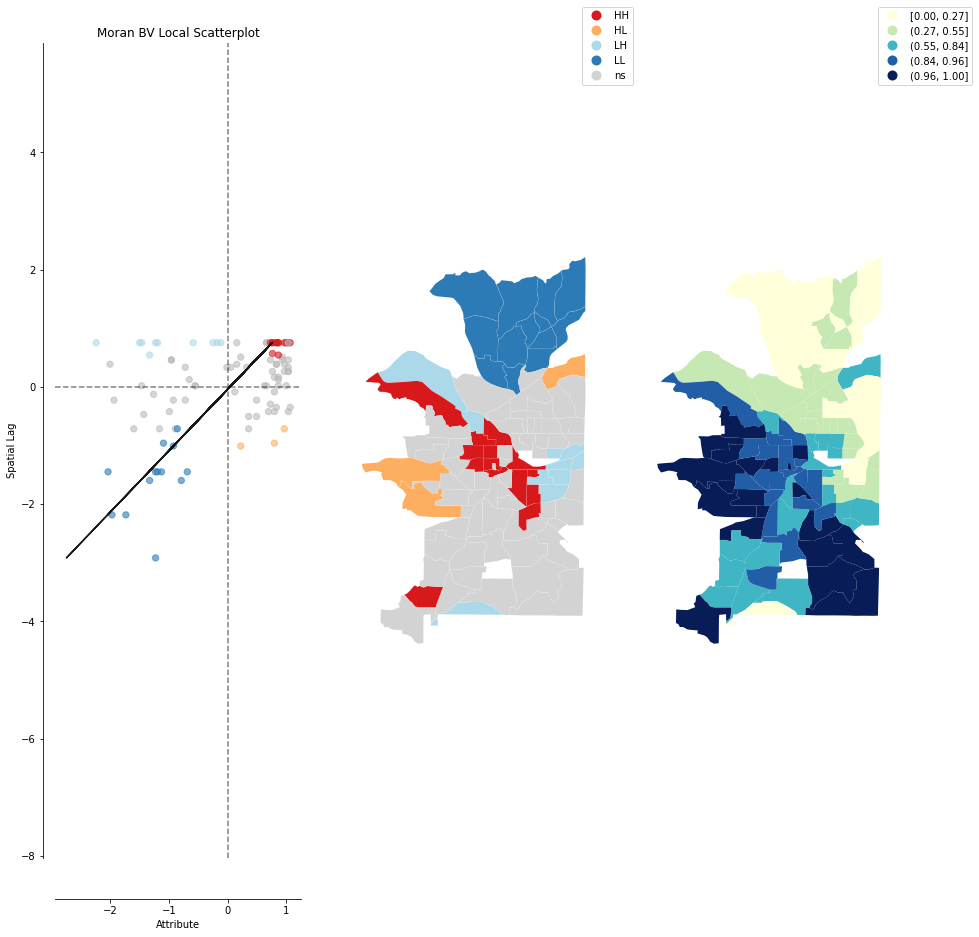

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, atlanta, 'perc_person_of_color', figsize=(15,15))
plt.show()

In [ ]:
#Getting cluster details - Gentrified
atlanta['cluster'] = moran_loc_bv.q 
atlanta[atlanta['cluster']==2]

,GEOID,geometry,state_name,county_name,total_index_quantile,perc_person_of_color,ordinal_value,city_name,rental_adj,minority_adj,cluster
1715,1.3121e+10,"MULTIPOLYGON (((-84.39298 33.76893, -84.39206 ...",Georgia,Fulton County,0.67,0.575494,4,Atlanta,3,3,2
1716,1.3121e+10,"MULTIPOLYGON (((-84.37433 33.75769, -84.37428 ...",Georgia,Fulton County,0.64,0.546465,4,Atlanta,3,3,2
1717,1.3121e+10,"MULTIPOLYGON (((-84.36579 33.75385, -84.36560 ...",Georgia,Fulton County,0.24,0.186723,4,Atlanta,1,1,2
1729,1.3121e+10,"MULTIPOLYGON (((-84.37986 33.73674, -84.37364 ...",Georgia,Fulton County,0.28,0.350929,4,Atlanta,2,2,2
1732,1.3121e+10,"MULTIPOLYGON (((-84.36392 33.77113, -84.35938 ...",Georgia,Fulton County,0.24,0.176335,4,Atlanta,1,1,2
1733,1.3121e+10,"MULTIPOLYGON (((-84.35824 33.75444, -84.35582 ...",Georgia,Fulton County,0.60,0.383021,4,Atlanta,3,2,2
1738,1.3121e+10,"MULTIPOLYGON (((-84.37363 33.76406, -84.37338 ...",Georgia,Fulton County,0.46,0.465791,4,Atlanta,2,2,2
1746,1.3121e+10,"MULTIPOLYGON (((-84.37664 33.74946, -84.36698 ...",Georgia,Fulton County,0.32,0.213731,4,Atlanta,2,1,2
1748,1.3121e+10,"MULTIPOLYGON (((-84.37370 33.71376, -84.37320 ...",Georgia,Fulton County,0.08,0.795302,3,Atlanta,1,4,2
1749,1.3121e+10,"MULTIPOLYGON (((-84.48553 33.81361, -84.48333 ...",Georgia,Fulton County,0.31,0.378292,4,Atlanta,2,2,2


In [ ]:
#Getting cluster details - New Minority Locations
atlanta['cluster'] = moran_loc_bv.q
atlanta[atlanta['cluster']==4]

,GEOID,geometry,state_name,county_name,total_index_quantile,perc_person_of_color,ordinal_value,city_name,rental_adj,minority_adj,cluster
1724,1.3121e+10,"MULTIPOLYGON (((-84.37757 33.80997, -84.37584 ...",Georgia,Fulton County,0.74,0.548136,4,Atlanta,3,3,4
1730,1.3121e+10,"MULTIPOLYGON (((-84.46563 33.73891, -84.45620 ...",Georgia,Fulton County,0.78,0.996732,2,Atlanta,4,4,4
1736,1.3121e+10,"MULTIPOLYGON (((-84.44687 33.73734, -84.44661 ...",Georgia,Fulton County,0.82,0.937165,3,Atlanta,4,4,4
1737,1.3121e+10,"MULTIPOLYGON (((-84.43258 33.71525, -84.43252 ...",Georgia,Fulton County,0.98,0.998326,3,Atlanta,4,4,4
1740,1.3121e+10,"MULTIPOLYGON (((-84.42737 33.72537, -84.42722 ...",Georgia,Fulton County,0.78,0.943320,4,Atlanta,4,4,4
1741,1.3121e+10,"MULTIPOLYGON (((-84.41816 33.71114, -84.41814 ...",Georgia,Fulton County,0.82,0.795046,3,Atlanta,4,4,4
1742,1.3121e+10,"MULTIPOLYGON (((-84.42929 33.69980, -84.42736 ...",Georgia,Fulton County,0.89,0.839955,3,Atlanta,4,4,4
1755,1.3121e+10,"MULTIPOLYGON (((-84.44658 33.75062, -84.44607 ...",Georgia,Fulton County,0.91,0.969006,4,Atlanta,4,4,4
1763,1.3121e+10,"MULTIPOLYGON (((-84.47374 33.73592, -84.47289 ...",Georgia,Fulton County,0.91,0.978702,3,Atlanta,4,4,4
1773,1.3121e+10,"MULTIPOLYGON (((-84.39874 33.78619, -84.39720 ...",Georgia,Fulton County,0.71,0.485900,3,Atlanta,3,2,4


## Exploring Gentrification in Boston

In [ ]:
boston_counties = ['Suffolk County']

boston = spatial_corr_data[(spatial_corr_data['county_name'].isin(boston_counties))&(spatial_corr_data['state_name']=='Massachusetts')]

boston = boston.dropna()

y = boston['total_index_quantile'].values
w = Queen.from_dataframe(boston)
w.transform = 'R'
x = boston['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

0.06343628545065509

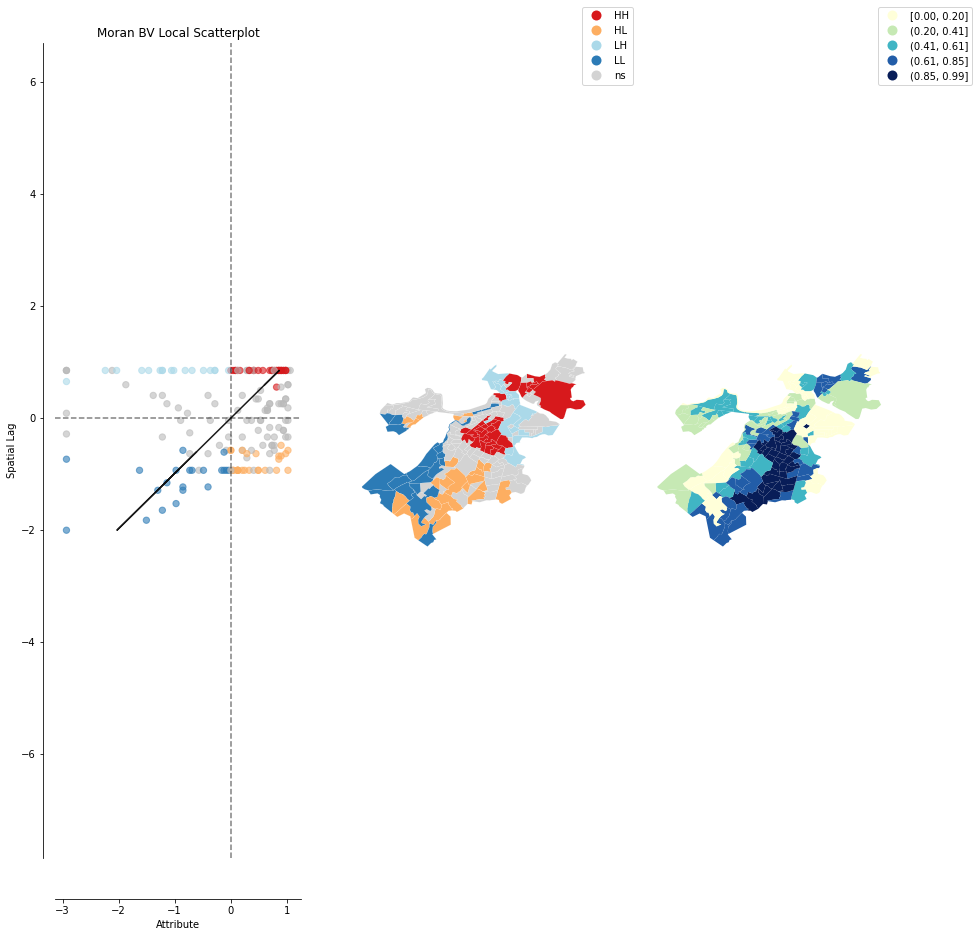

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, boston, 'perc_person_of_color', figsize=(15,15))
plt.show()

## Exploring Gentrification in Chicago

In [ ]:
#Chicago Redline Index and Rental Assistance Correlation

chicago_counties = ['Cook County']

chicago = spatial_corr_data[(spatial_corr_data['county_name'].isin(chicago_counties))&(spatial_corr_data['state_name']=='Illinois')]

chicago = chicago.dropna()

y = chicago['total_index_quantile'].values
w = Queen.from_dataframe(chicago)
w.transform = 'R'
x = chicago['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

0.23845302318147094

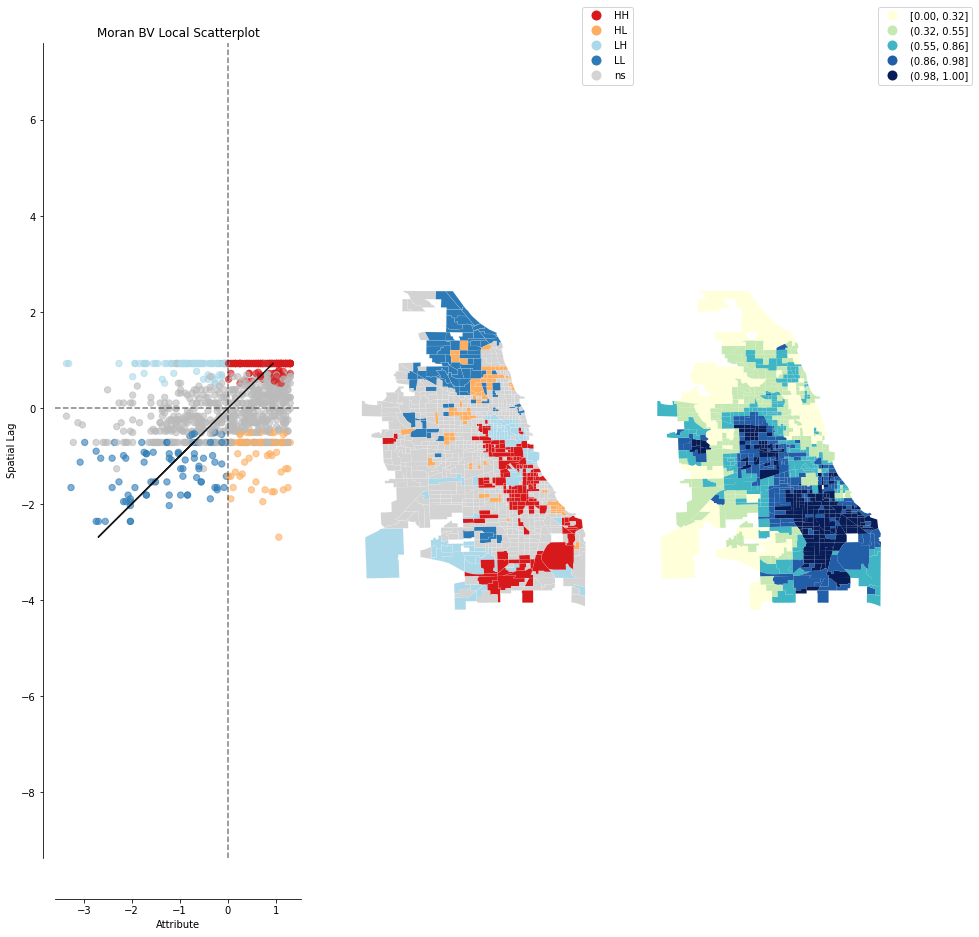

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, chicago, 'perc_person_of_color', figsize=(15,15))
plt.show()

## Exploring Gentrification in Dallas

In [ ]:
#Dallas Racial Minority and Rental Assistance Correlation

dallas_counties = ['Dallas County']

dallas = spatial_corr_data[(spatial_corr_data['county_name'].isin(dallas_counties))&(spatial_corr_data['state_name']=='Texas')]

dallas = dallas.dropna()

y = dallas['total_index_quantile'].values
w = Queen.from_dataframe(dallas)
w.transform = 'R'
x = dallas['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

0.5872307520983077

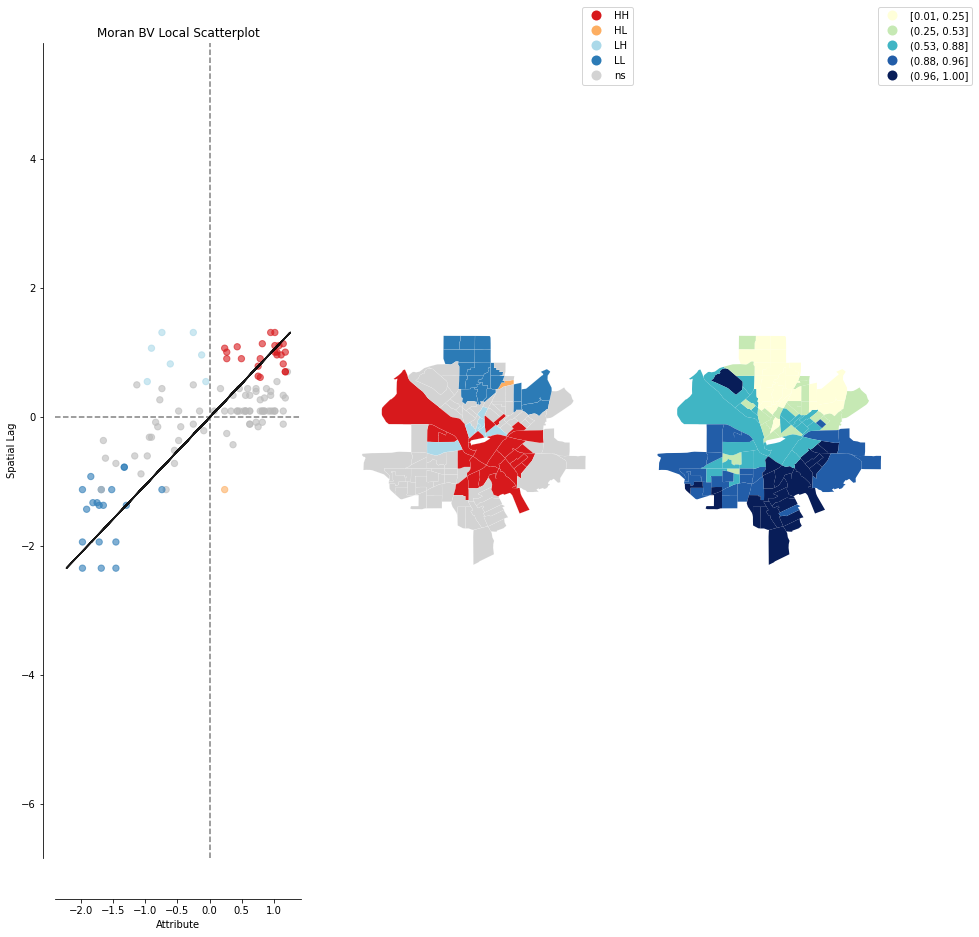

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, dallas, 'perc_person_of_color', figsize=(15,15))
plt.show()

## Exploring Gentrification in Detroit

In [ ]:
#Detroit Racial Minority and Rental Assistance Correlation

detroit_counties = ['Wayne County']

detroit = spatial_corr_data[(spatial_corr_data['county_name'].isin(detroit_counties))&(spatial_corr_data['state_name']=='Michigan')]

t=[26163571800]
detroit = detroit.loc[~detroit.GEOID.isin(t)]

detroit = detroit.dropna()

y = detroit['total_index_quantile'].values
w = Queen.from_dataframe(detroit)
w.transform = 'R'
x = detroit['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

0.1353091010976185

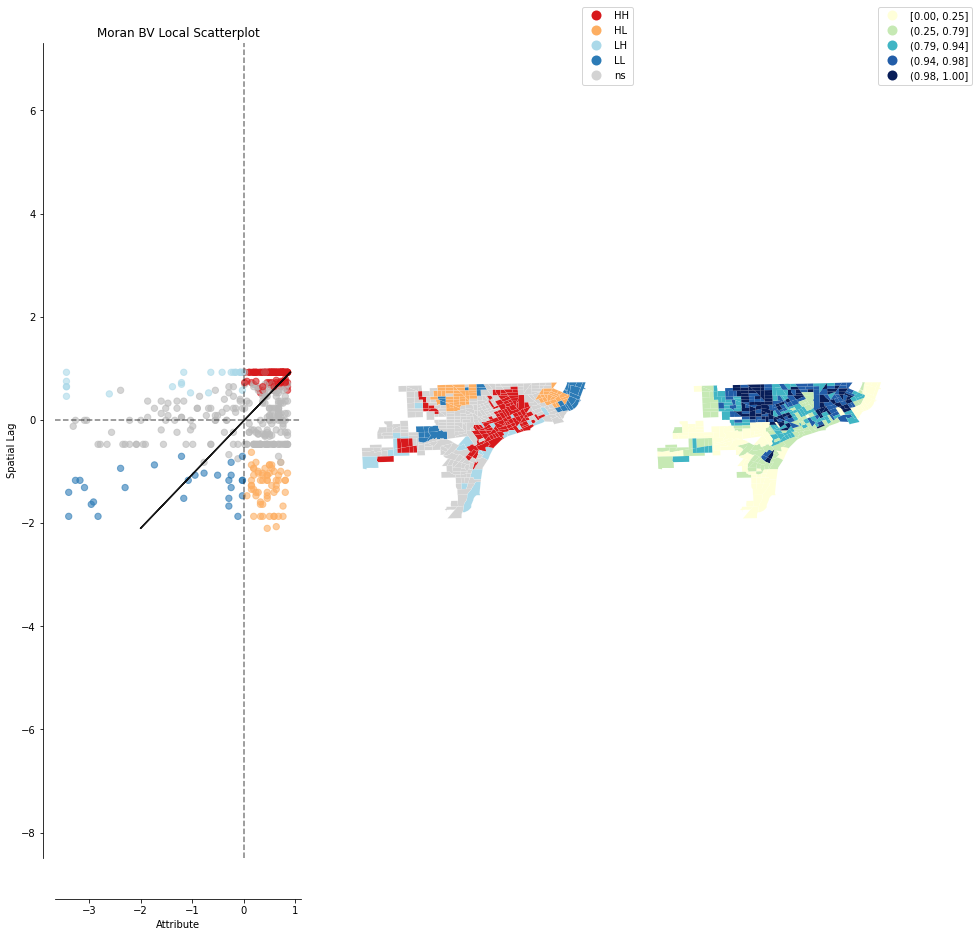

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, detroit, 'perc_person_of_color', figsize=(15,15))
plt.show()

## Exploring Gentrification in Houston

In [ ]:
#Houston Racial Minority and Rental Assistance Correlation

houston_counties = ['Harris County']

houston = spatial_corr_data[(spatial_corr_data['county_name'].isin(houston_counties))]

houston = houston.dropna()

y = houston['total_index_quantile'].values
w = Queen.from_dataframe(houston)
w.transform = 'R'
x = houston['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

0.211041432870195

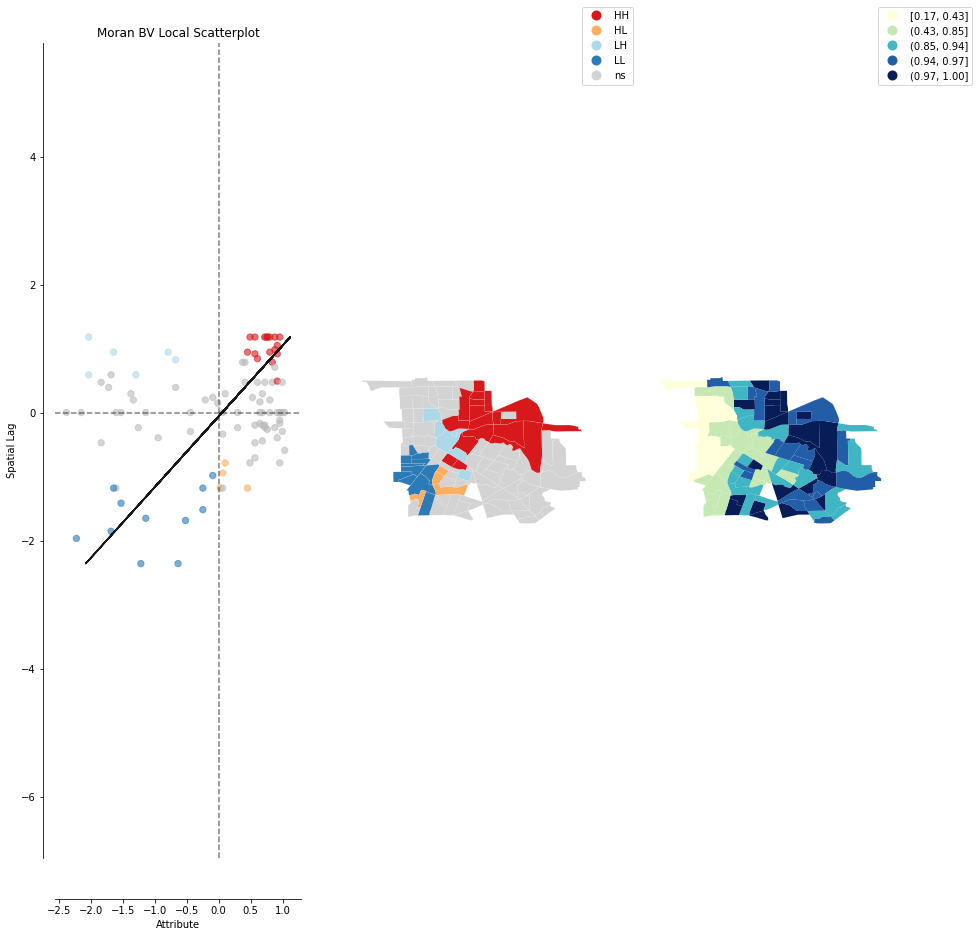

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, houston, 'perc_person_of_color', figsize=(15,15))
plt.show()

## Exploring Gentrification in Los Angeles

In [ ]:
#LA Rental Assistance and Redline Correlation

la_counties = ['Los Angeles County']

la = spatial_corr_data[spatial_corr_data['county_name'].isin(la_counties)]

la = la.dropna()

t=[6037401311]
la = la.loc[~la.GEOID.isin(t)]

y = la['total_index_quantile'].values
w = Queen.from_dataframe(la)
w.transform = 'R'
x = la['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

/opt/venv/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  warnings.warn(message)


0.33347343228982607

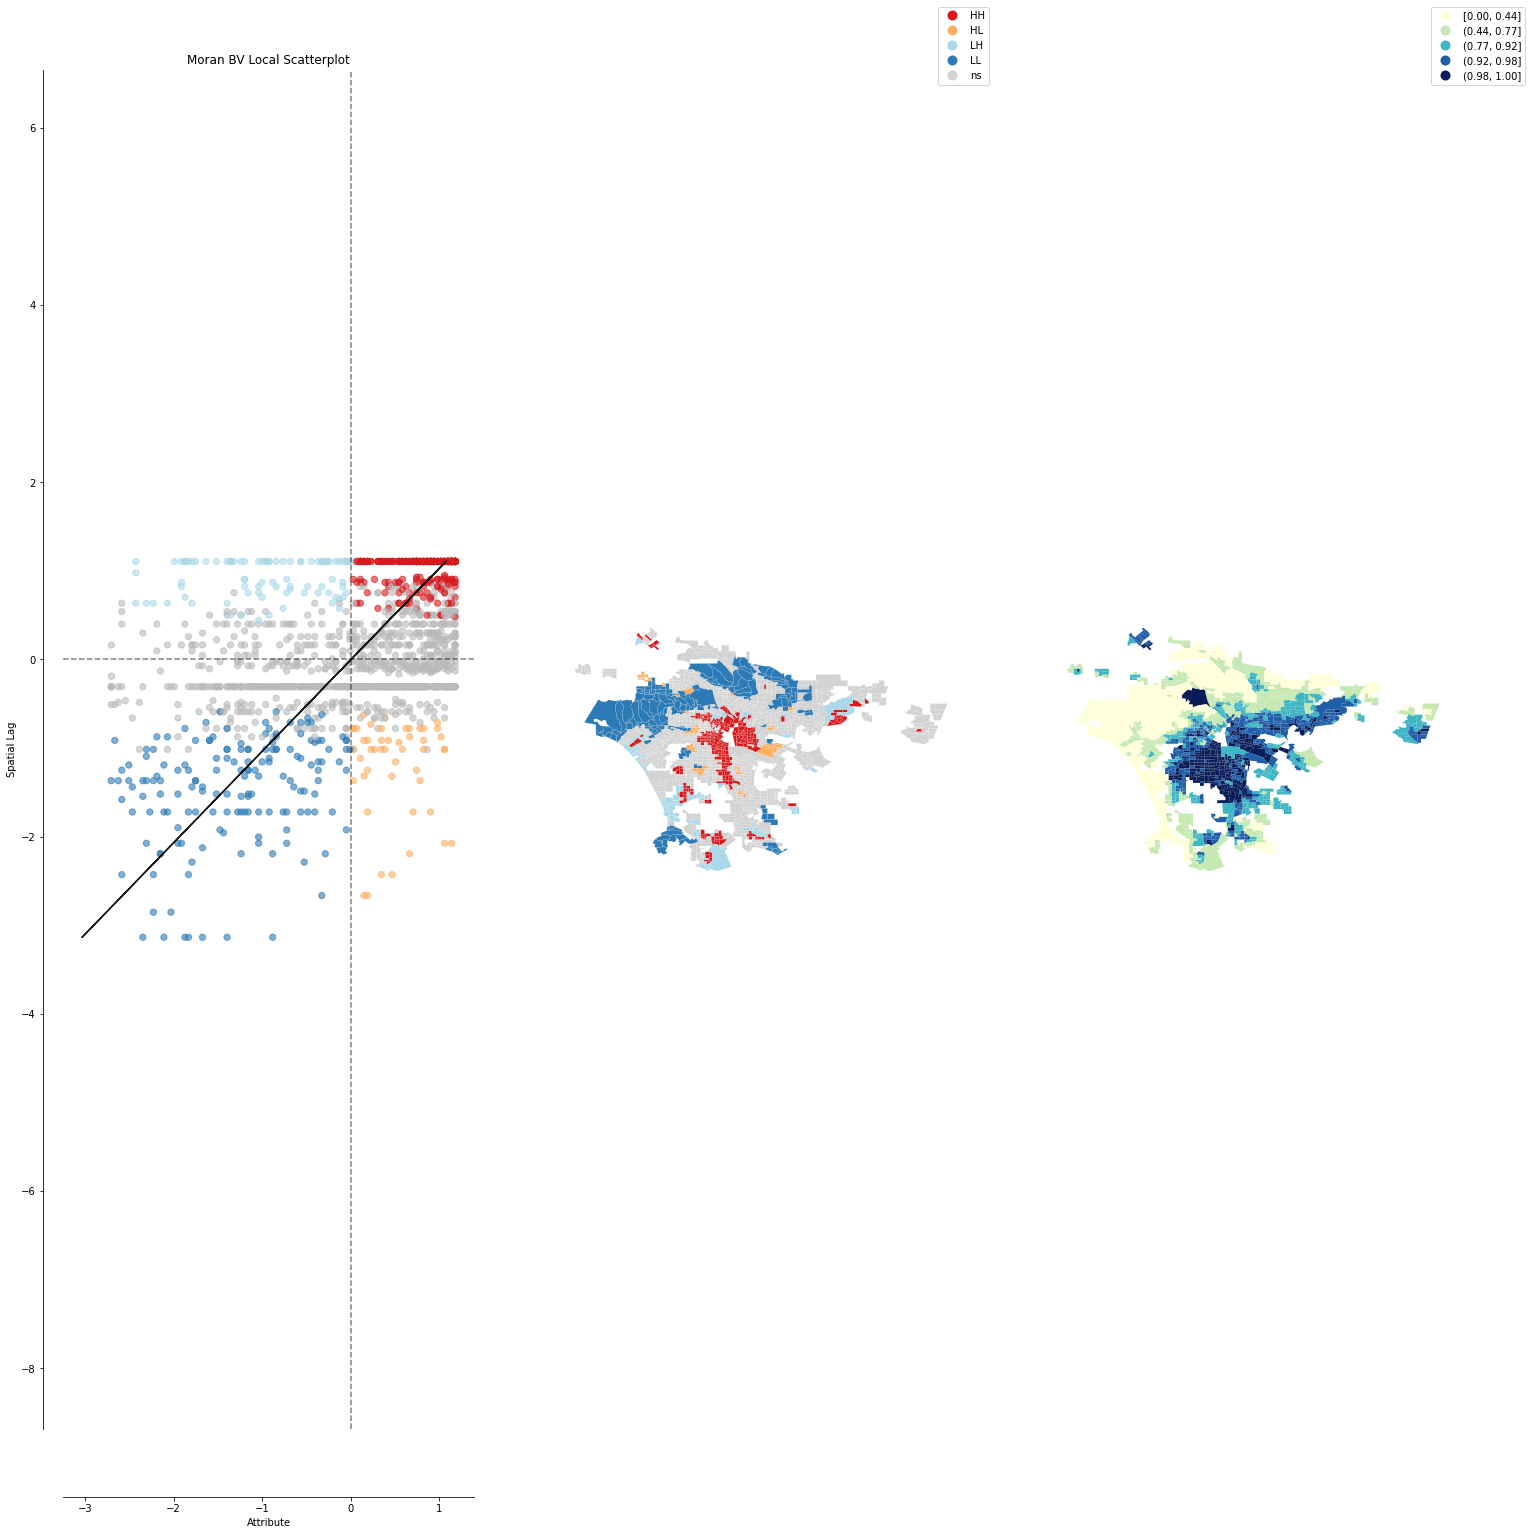

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, la, 'perc_person_of_color', figsize=(25,25))
plt.show()

## Exploring Gentrification in Minneapolis

In [ ]:
#Minneapolis Racial Minority and Rental Assistance Correlation

minneapolis_counties = ['Hennepin County']

minneapolis = spatial_corr_data[spatial_corr_data['county_name'].isin(minneapolis_counties)]

minneapolis = minneapolis.dropna()

y = minneapolis['total_index_quantile'].values
w = Queen.from_dataframe(minneapolis)
w.transform = 'R'
x = minneapolis['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

0.48383101395769745

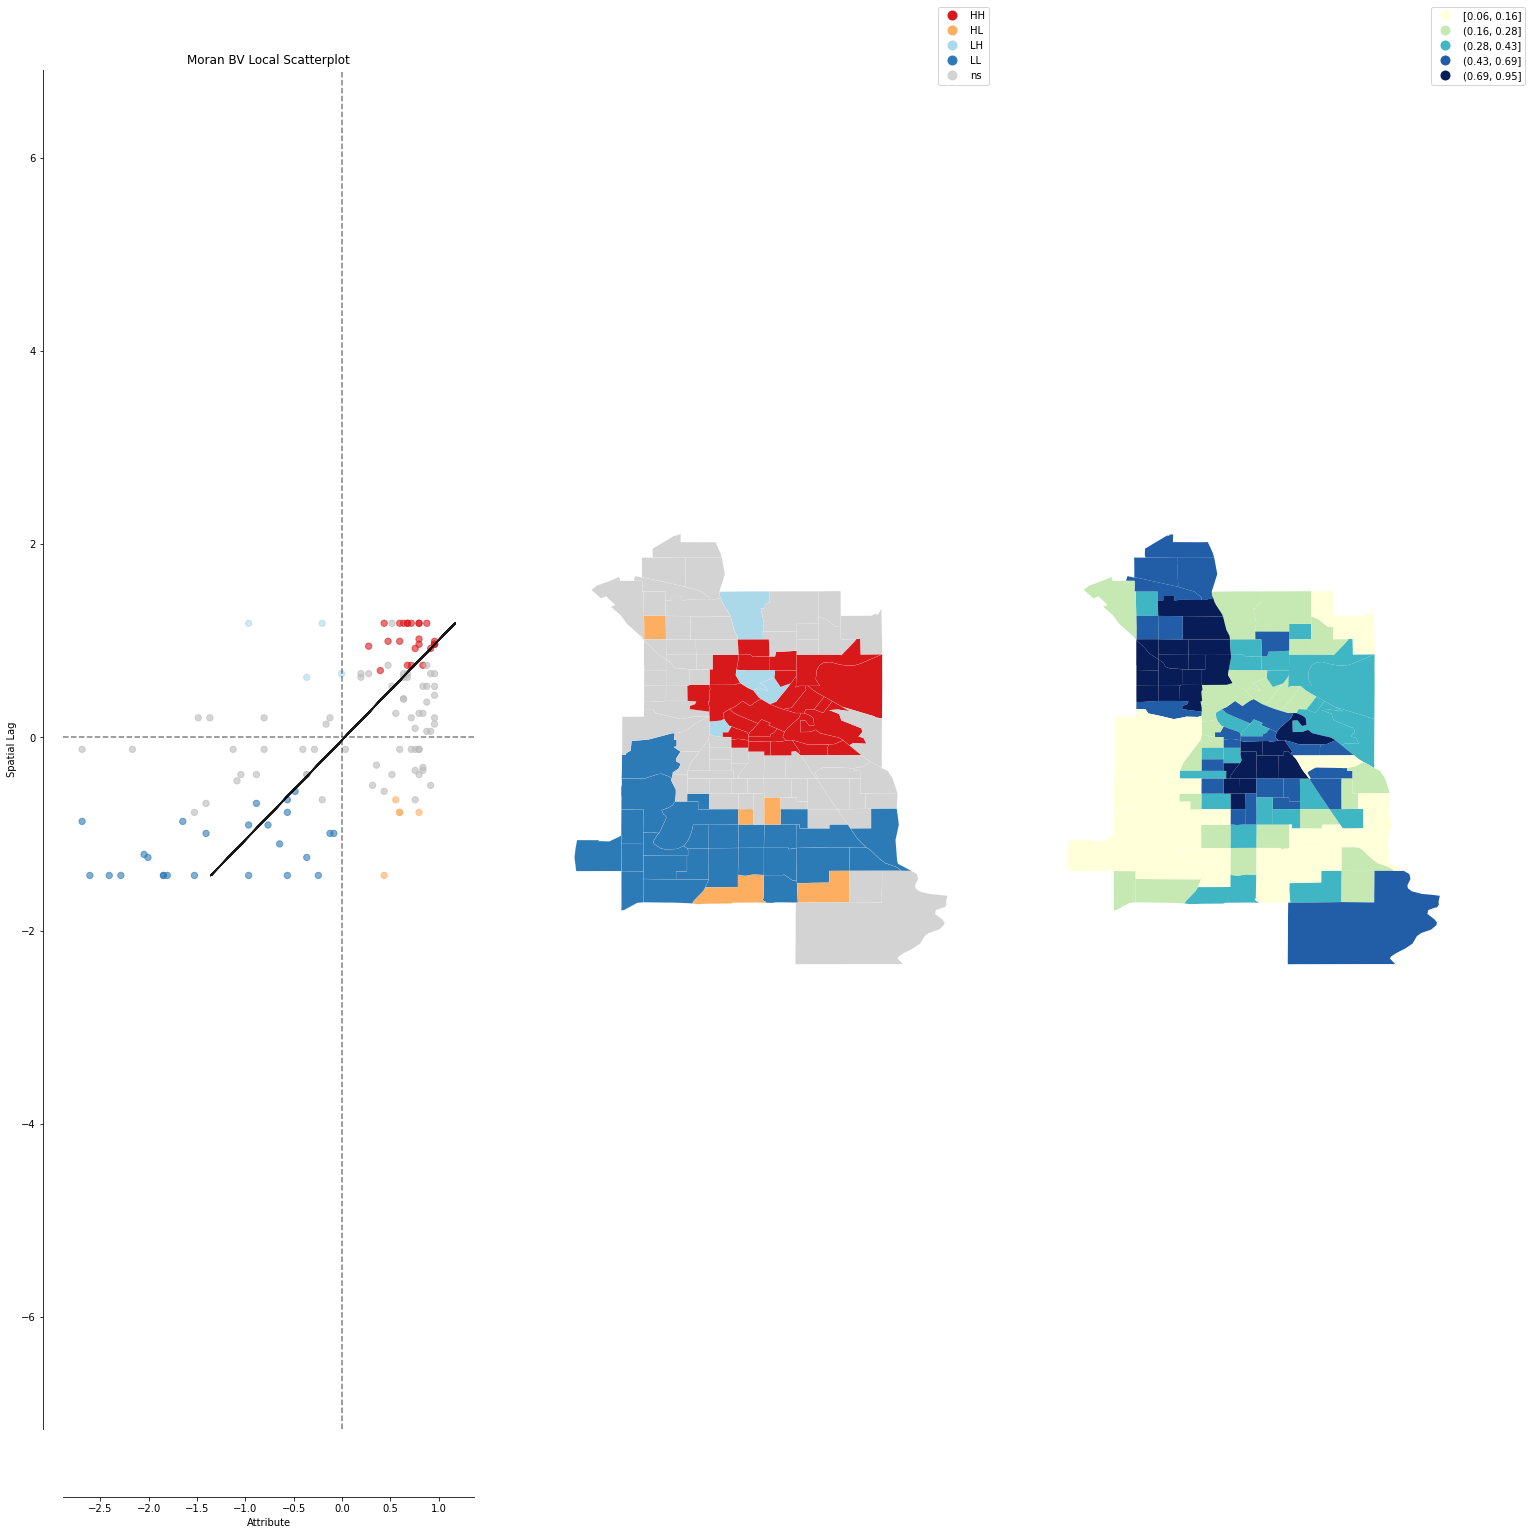

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, minneapolis, 'perc_person_of_color', figsize=(25,25))
plt.show()

## Exploring Gentrification in Nashville

In [ ]:
#Nashville Racial Minority and Rental Assistance Correlation

nashville_counties = ['Davidson County']

nashville = spatial_corr_data[(spatial_corr_data['county_name'].isin(nashville_counties))]

nashville = nashville.dropna()

y = nashville['ordinal_value'].values
w = Queen.from_dataframe(nashville)
w.transform = 'R'
x = nashville['total_index_quantile'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

0.6152230420358129

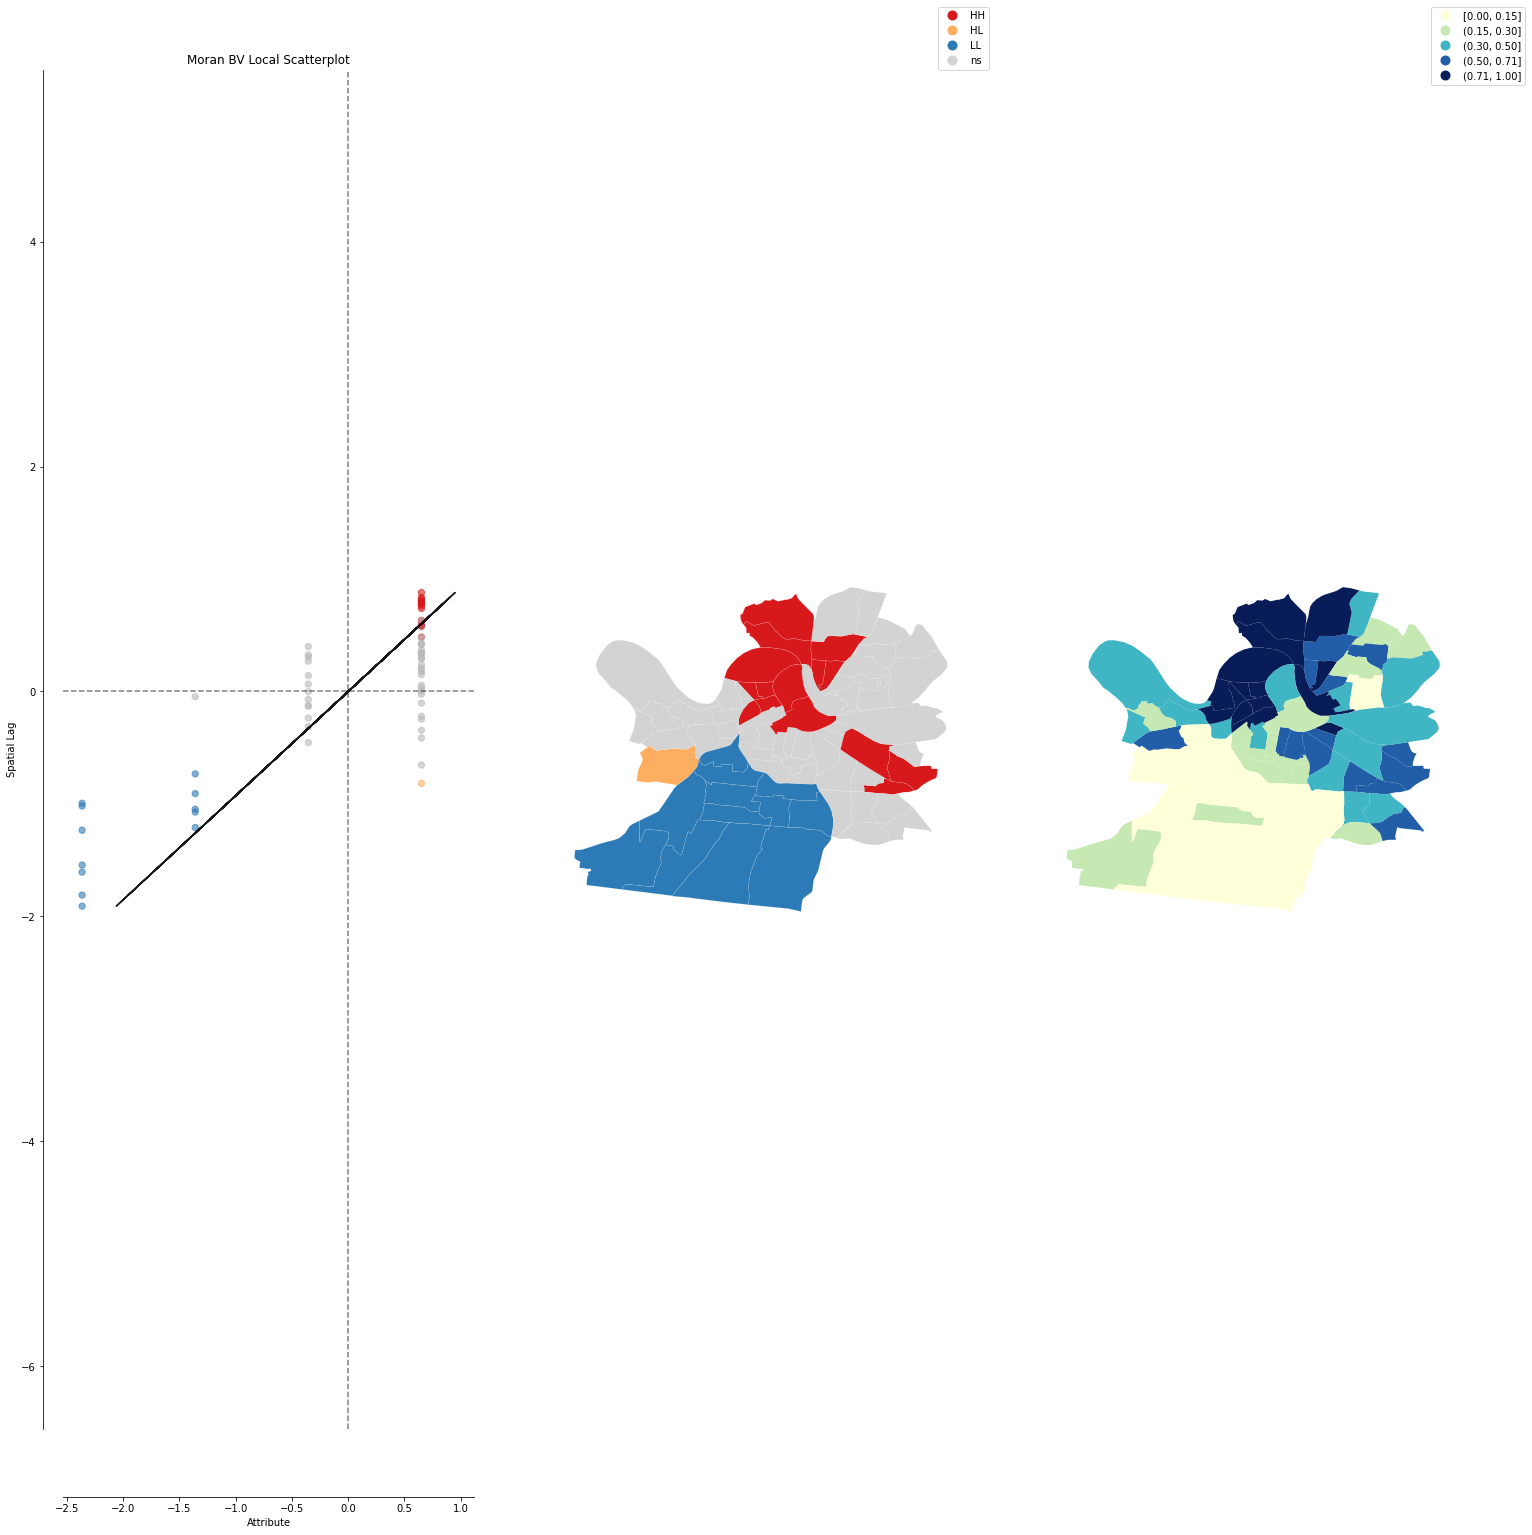

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, nashville, 'perc_person_of_color', figsize=(25,25))
plt.show()

## Exploring Gentrification in New York

In [ ]:
#NY Redline Index and Rental Assistance Correlation
ny_counties = ['Kings County','Richmond County', 'Bronx County', ' Queens County', 'New York County']
ny = spatial_corr_data[spatial_corr_data['county_name'].isin(ny_counties)]

t=['36061000100']
ny = ny.loc[~ny.GEOID.isin(t)]

ny = ny.dropna()

y = ny['total_index_quantile'].values
w = Queen.from_dataframe(ny)
w.transform = 'R'
x = ny['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

/opt/venv/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.16090135914027026

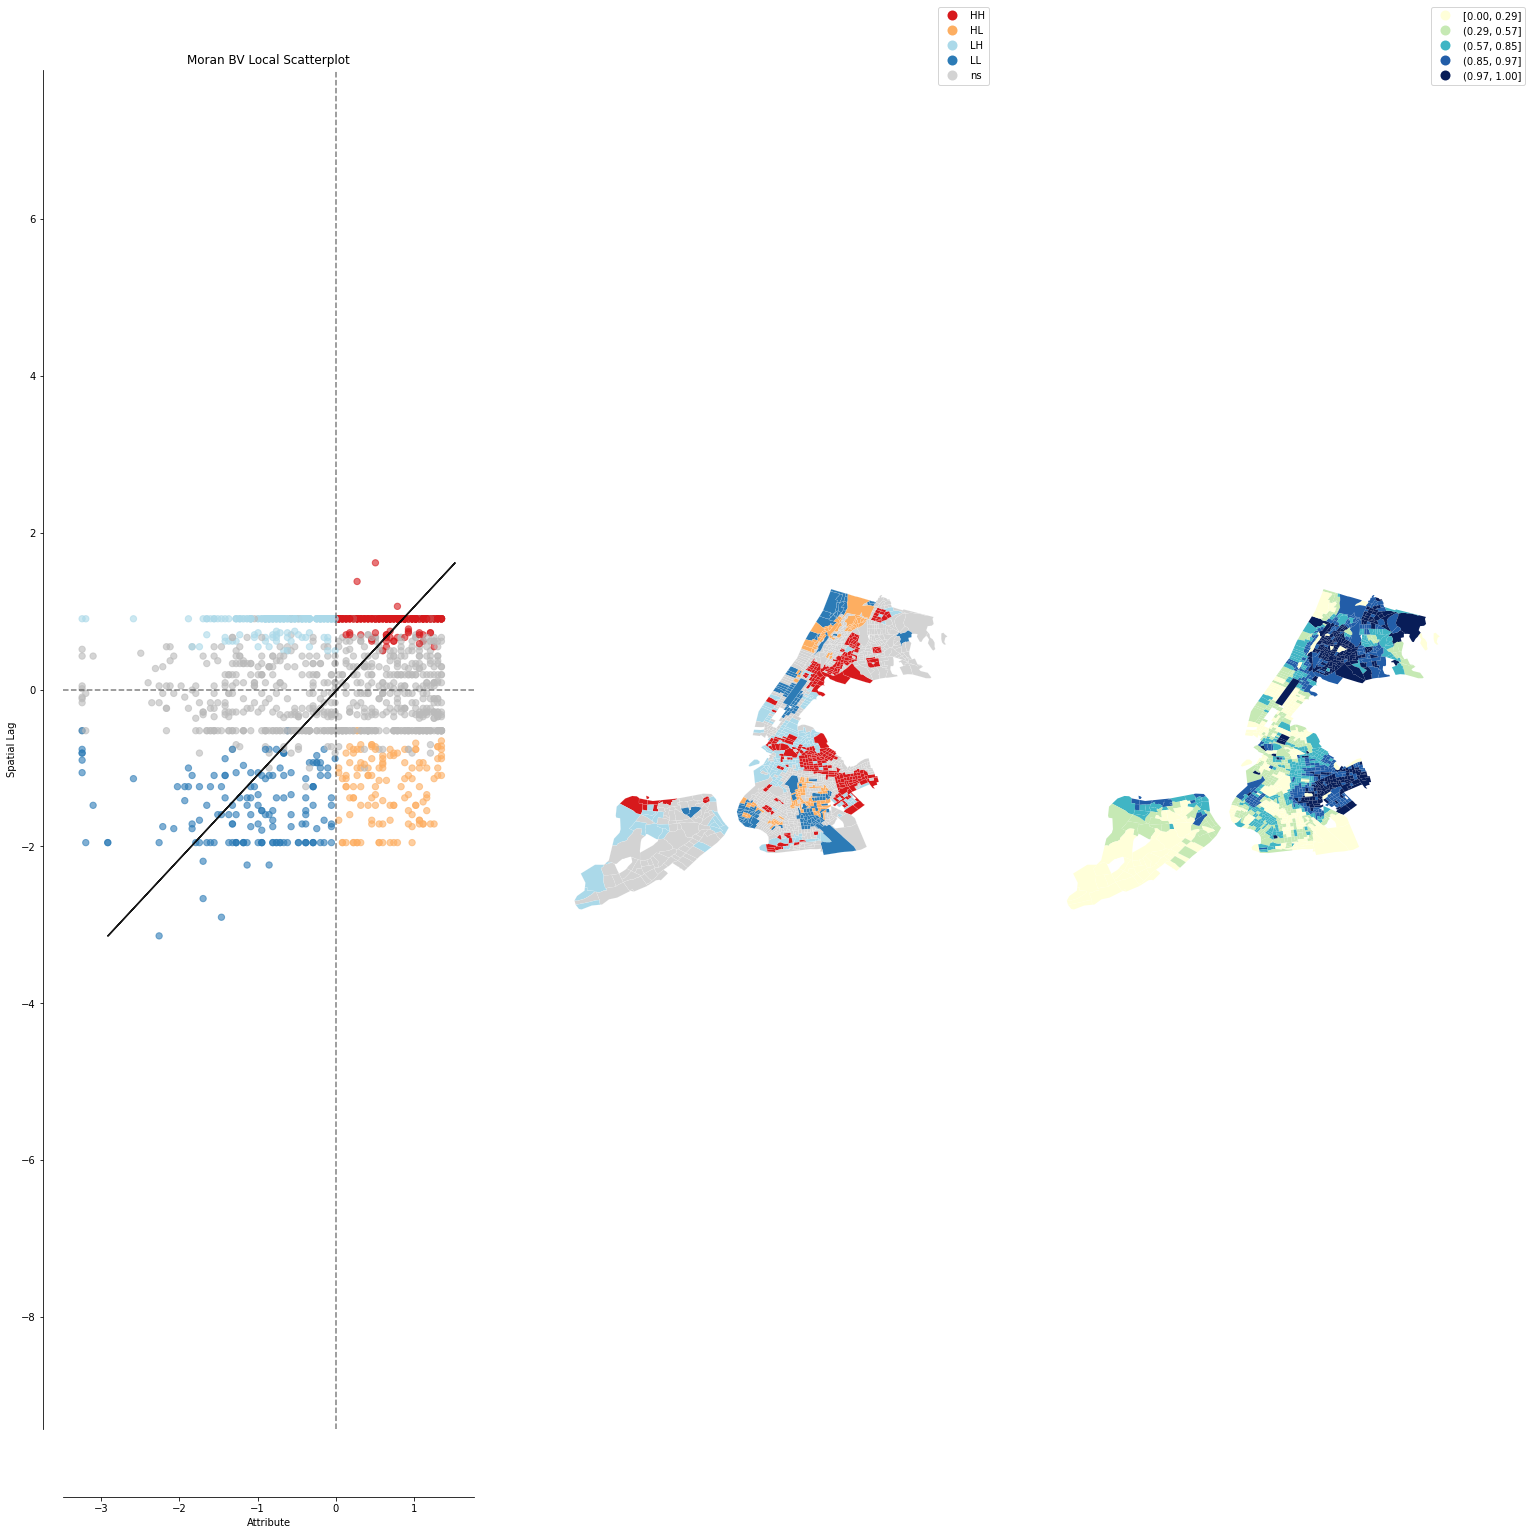

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, ny, 'perc_person_of_color', figsize=(25,25))
plt.show()

## Exploring Gentrification in Newark

In [ ]:
#Newark Racial Minority and Rental Assistance Correlation

newark_counties = ['Essex County']

newark = spatial_corr_data[(spatial_corr_data['county_name'].isin(newark_counties))&(spatial_corr_data['state_name']=='New Jersey')]

newark = newark.dropna()

y = newark['total_index_quantile'].values
w = Queen.from_dataframe(newark)
w.transform = 'R'
x = newark['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

0.5685705220746252

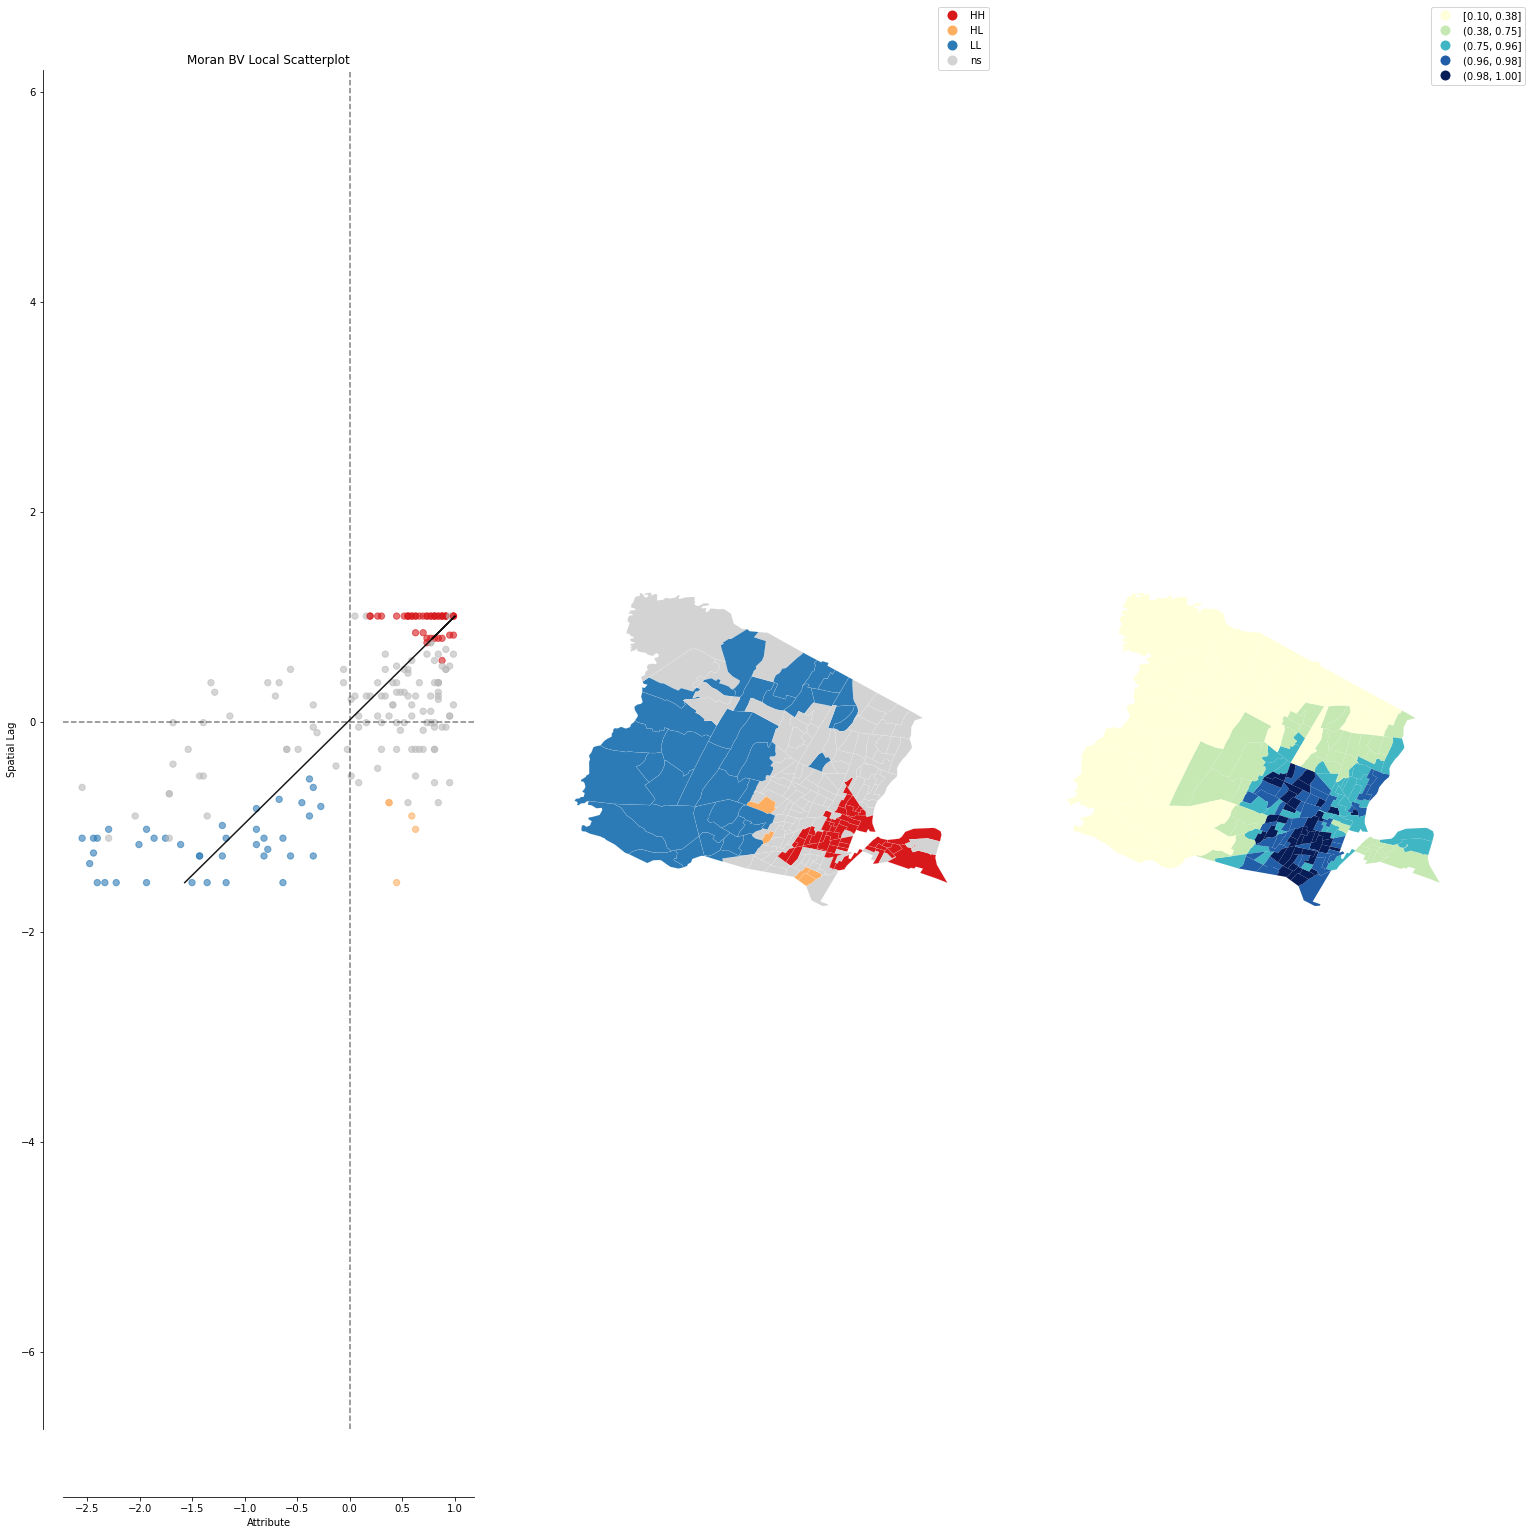

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, newark, 'perc_person_of_color', figsize=(25,25))
plt.show()

## Exploring Gentrification in San Francisco

In [ ]:
#SF Racial Minority and Rental Assistance Correlation

sf_counties = ['San Francisco County']

sf = spatial_corr_data[spatial_corr_data['county_name'].isin(sf_counties)]

sf = sf.dropna()

t=['06075980401']
sf = sf.loc[~sf.GEOID.isin(t)]

y = sf['total_index_quantile'].values
w = Queen.from_dataframe(sf)
w.transform = 'R'
x = sf['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

0.2317149750093735

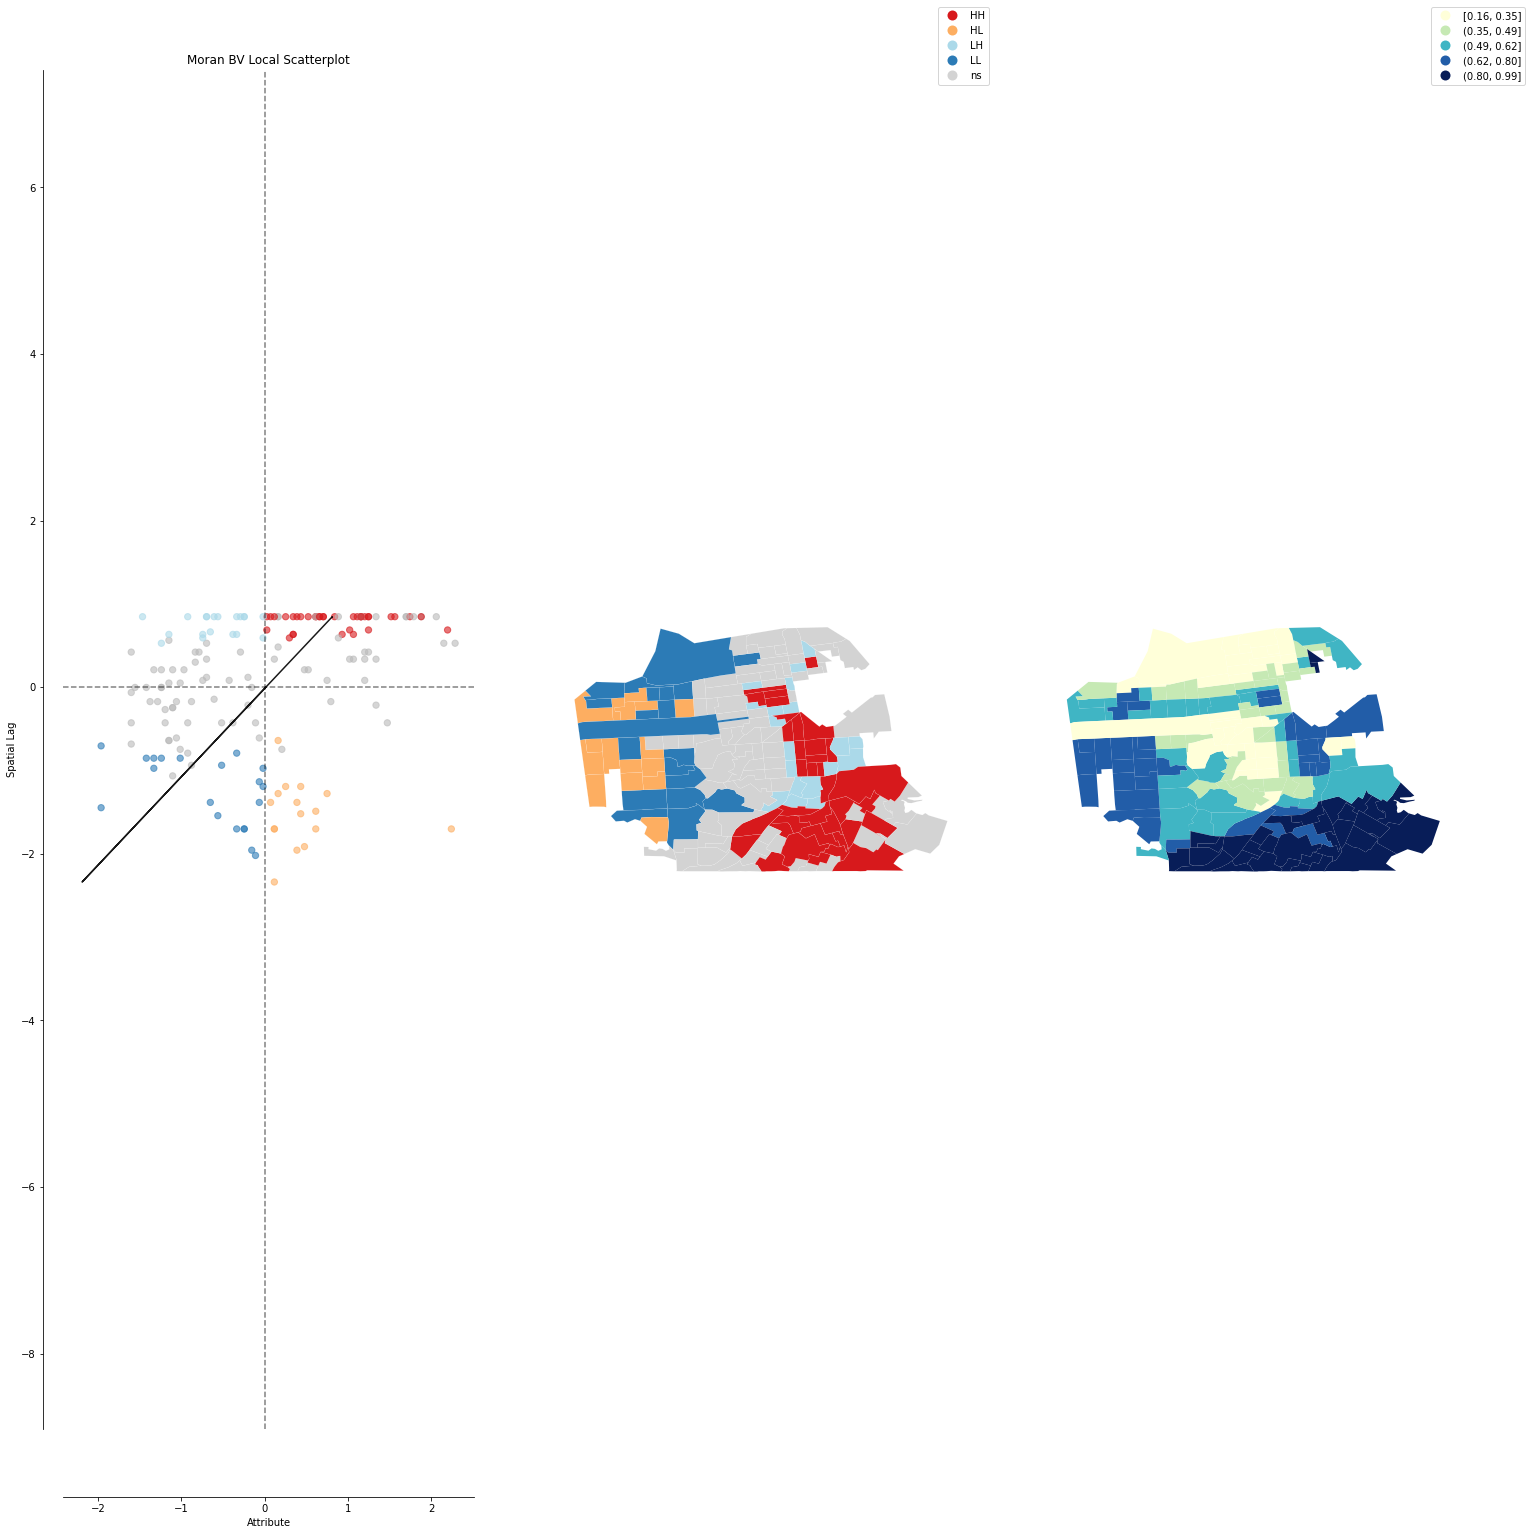

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, sf, 'perc_person_of_color', figsize=(25,25))
plt.show()

## Exploring Gentrification in St. Louis

In [ ]:
#St Louis Racial Minority and Rental Assistance Correlation

stlouis_counties = ['St. Louis County']

stlouis = spatial_corr_data[(spatial_corr_data['county_name'].isin(stlouis_counties))]

stlouis = stlouis.dropna()

y = stlouis['total_index_quantile'].values
w = Queen.from_dataframe(stlouis)
w.transform = 'R'
x = stlouis['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

0.20960673916657724

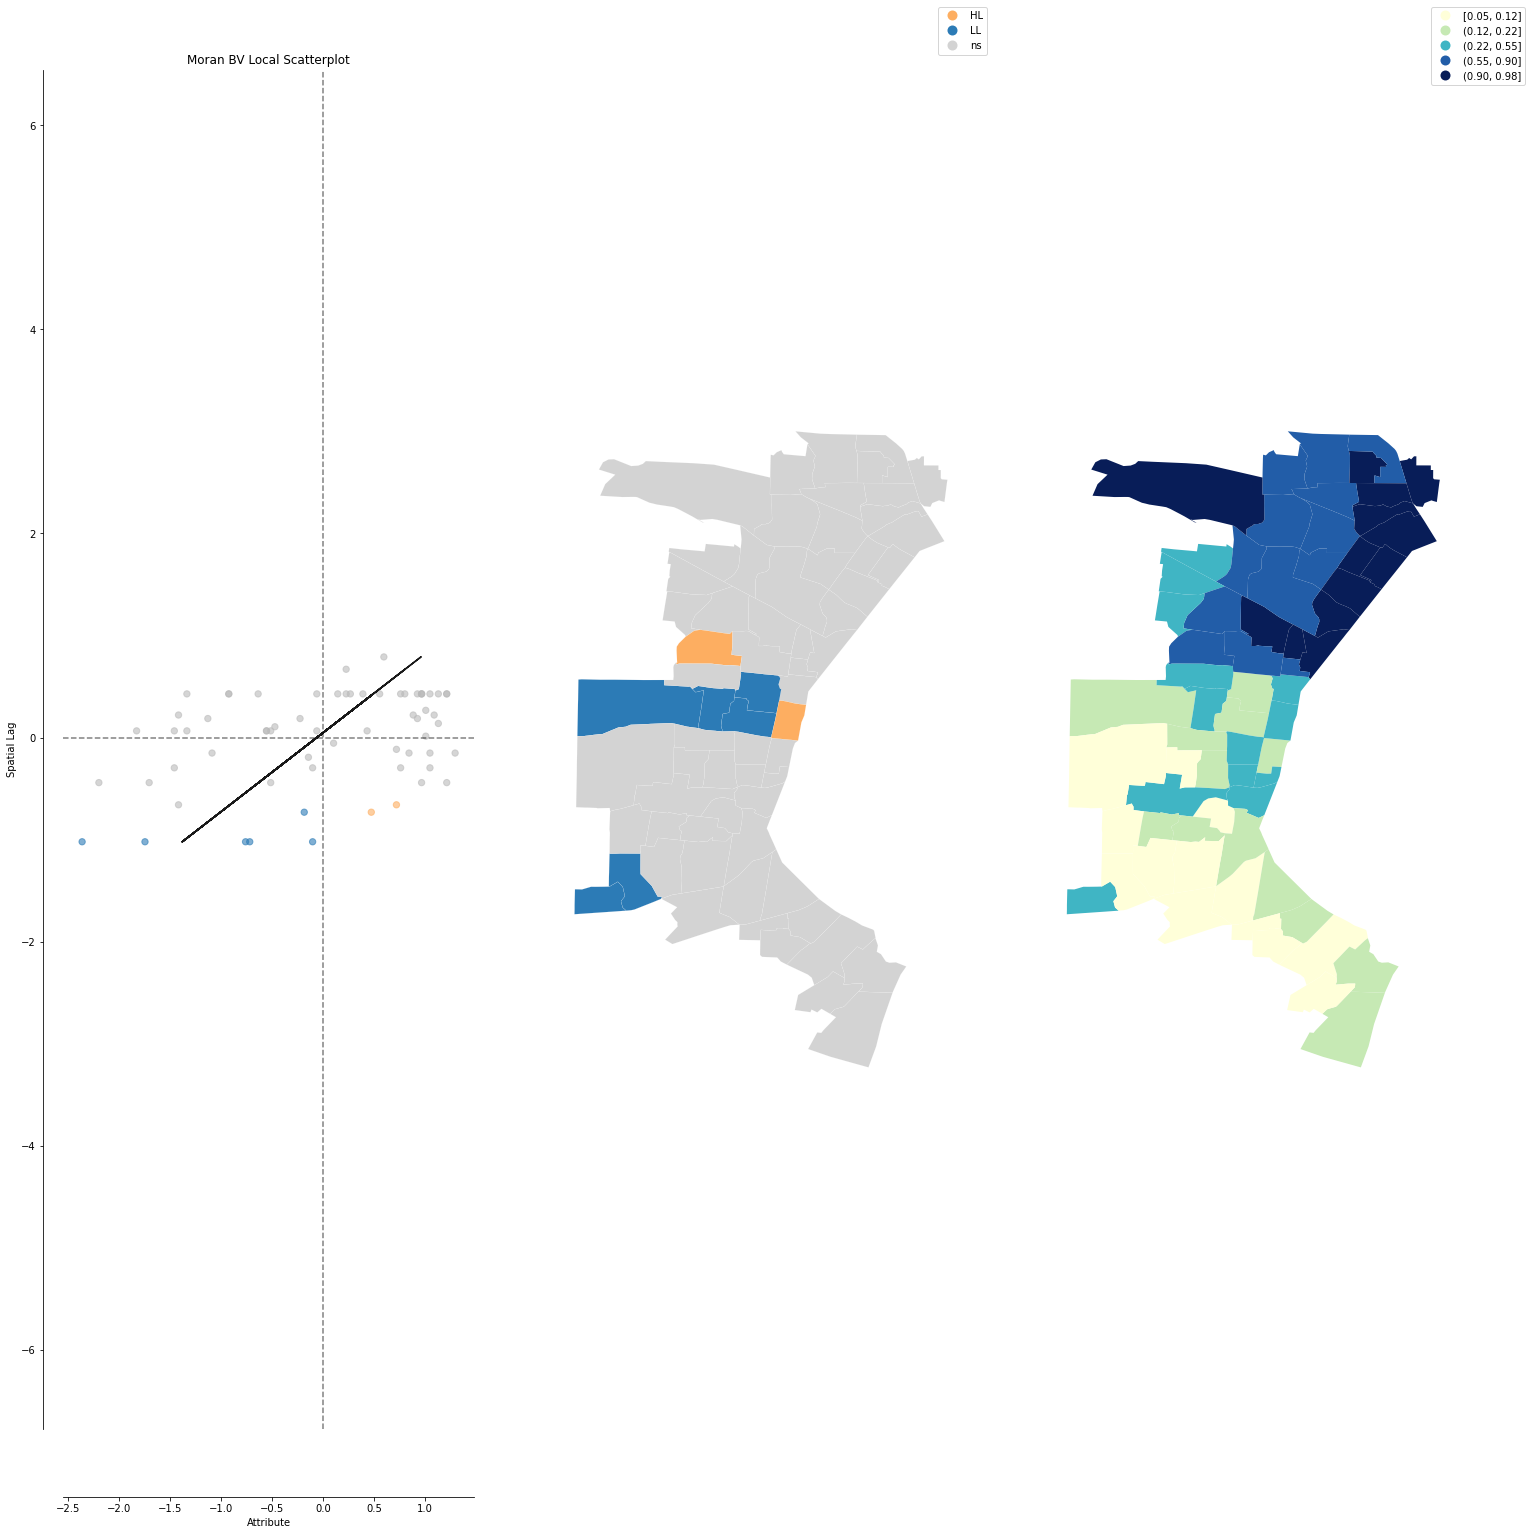

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, stlouis, 'perc_person_of_color', figsize=(25,25))
plt.show()

## Exploring Gentrification in Tampa

In [ ]:
#Tampa Racial Minority and Rental Assistance Correlation

tampa_counties = ['Hillsborough County']

tampa = spatial_corr_data[(spatial_corr_data['county_name'].isin(tampa_counties))&(spatial_corr_data['state_name']=='Florida')]

tampa = tampa.dropna()

y = tampa['total_index_quantile'].values
w = Queen.from_dataframe(tampa)
w.transform = 'R'
x = tampa['ordinal_value'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w)
moran_bv.I

/opt/venv/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


0.4169572871860898

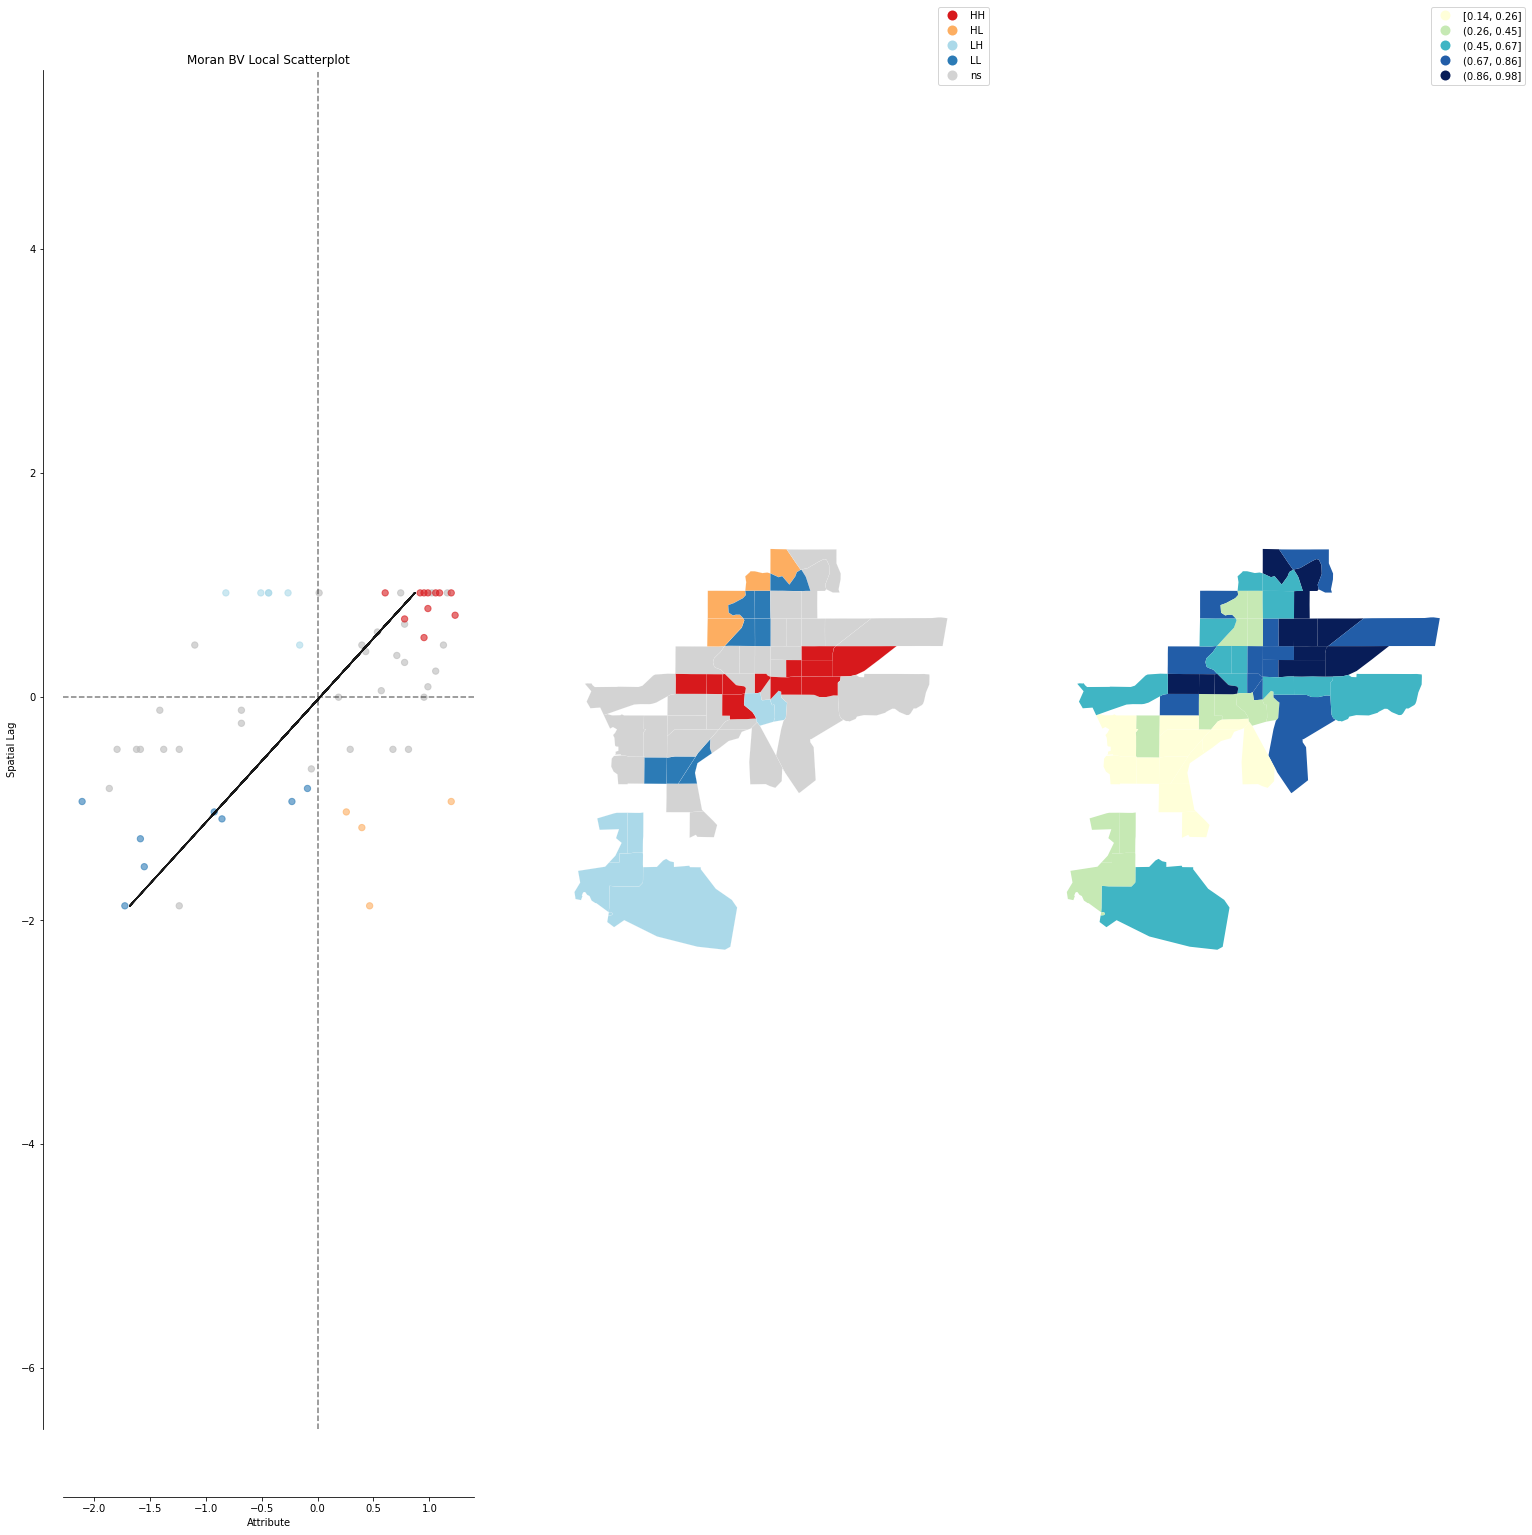

In [ ]:
#Plotting Local Autocorrelations for bivariate relationship between tests done between October and September against cases confirmed in October
plot_local_autocorrelation(moran_loc_bv, tampa, 'perc_person_of_color', figsize=(25,25))
plt.show()

In [ ]:
import shutil
shutil.move("/work/COVIDRedlining/correlations.ipynb", "/work/COVIDRedlining/EDA/")

'/work/COVIDRedlining/EDA/correlations.ipynb'

In [ ]:
shutil.move("path/to/current/file.foo", "path/to/new/destination/for/file.foo")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c9a4f701-31a5-4164-b3f3-c09cddf1309e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>